<a href="https://colab.research.google.com/github/am610/SN_lsst_analysis/blob/main/Ayan/Load_large_model_PLOT_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install astronn

In [2]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_smoothed_curve(z_or, prediction, sigma, curve_type='lower', frac=0.05):
    """
    Get the smoothed curve based on the provided data and curve type.

    Parameters:
    - z_or: Original x-values.
    - prediction: Central prediction values.
    - sigma: Error values.
    - curve_type: String, either 'upper' or 'lower'. Specifies which curve to return.
    - frac: Fraction for lowess smoothing.

    Returns:
    - smoothed_curve: Array with two columns, the first being x-values and the second being y-values of the smoothed curve.
    """
    if curve_type == 'lower':
        prediction_curve = prediction - sigma
    elif curve_type == 'upper':
        prediction_curve = prediction + sigma
    else:
        raise ValueError("curve_type must be either 'upper' or 'lower'")

    f = interp1d(z_or.flatten(), prediction_curve)

    new_z_or = np.linspace(min(z_or.flatten()), max(z_or.flatten()), 100)
    interpolated_values = f(new_z_or)
    smoothed_curve = lowess(interpolated_values, new_z_or.ravel(), frac=frac)

    return smoothed_curve



# Large data set

In [4]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Isidro/SN_lsst_analysis/models/large_lsst_model.h5', custom_objects={'MCDropout': MCDropout})

In [5]:
data_folder = '/content/drive/MyDrive/Isidro/SN_lsst_analysis/Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [6]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


In [7]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [8]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)


In [9]:
scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

In [10]:
# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)


181/181 [==============================] - 0s 2ms/step


In [11]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2

def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

<ipython-input-17-2b54850060ca>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  a2.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.',markersize=8, color='g', capsize=3, elinewidth=1,alpha=0.05);
<ipython-input-17-2b54850060ca>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  a2.errorbar(df_data['zCMB'][100], df_data['MU'][100]-19, df_data['errors'][100], fmt='g.',markersize=8, color='g', capsize=3, elinewidth=1, alpha=0.99, label='Observations');


<Figure size 800x500 with 0 Axes>

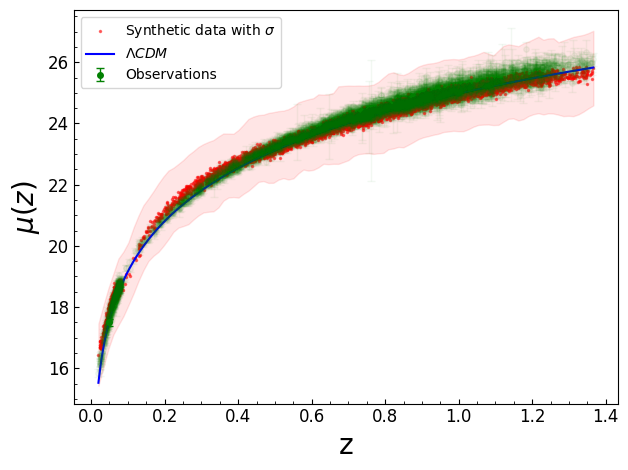

In [17]:
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
# Plotting
plt.figure(figsize=(8, 5), dpi=100)
f, a2 = plt.subplots()
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2);
a2.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.',markersize=8, color='g', capsize=3, elinewidth=1,alpha=0.05);
a2.errorbar(df_data['zCMB'][100], df_data['MU'][100]-19, df_data['errors'][100], fmt='g.',markersize=8, color='g', capsize=3, elinewidth=1, alpha=0.99, label='Observations');
a2.plot(z_or, prediction_mc_dropout[:,0]-19,'.',c='r',alpha=0.5,markersize=3,label='Synthetic data with $\sigma$');
a2.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b');

smoothed_lower = get_smoothed_curve(z_or, prediction_mc_dropout[:,0]-19, sigma, curve_type='lower');
smoothed_upper = get_smoothed_curve(z_or, prediction_mc_dropout[:,0]-19, sigma, curve_type='upper');

a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='red', alpha=0.1);


# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20);
plt.xlabel("z", fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.minorticks_on()
a2.tick_params(axis='both', direction="in", which='minor', labelsize=15)
a2.tick_params(axis='both', direction="in", which='major', labelsize=12)

# plt.legend(loc='best')
plt.legend(loc='upper left');
# plt.show()
plt.tight_layout();